# Autoencoder

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-18.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Create a simple autoencoder for feature extraction, dimensionality reduction and reconstruction of images.

An [autoencoder](https://en.wikipedia.org/wiki/Autoencoder), also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of unlabeled inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression. Autoencoders, based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of [Deep Belief Networks (DBN)](https://en.wikipedia.org/wiki/Deep_belief_network).

An autoencoder can be divided in two parts, the encoder and the decoder. The encoder compress the representation of an input by running the data through its layers. The decoder works like encoder network in reverse. It works to recreate the input as closely as possible. The training procedure produces at the center of the network a compressed, low dimensional representation that can be decoded to obtain the higher dimensional representation with minimal loss of information between the input and the output.

## Import libraries

In [1]:
import tensorflow as tf
from keras import datasets, layers, losses, optimizers, Model
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-03-07 02:18:06.120049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741335486.135131  440631 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741335486.139537  440631 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 02:18:06.152830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the dataset

In [2]:
(X_train, _), (X_test, _) = datasets.mnist.load_data()
X_train, X_test = X_train.astype('float32') / 255, X_test.astype('float32') / 255

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


## Visualize the dataset

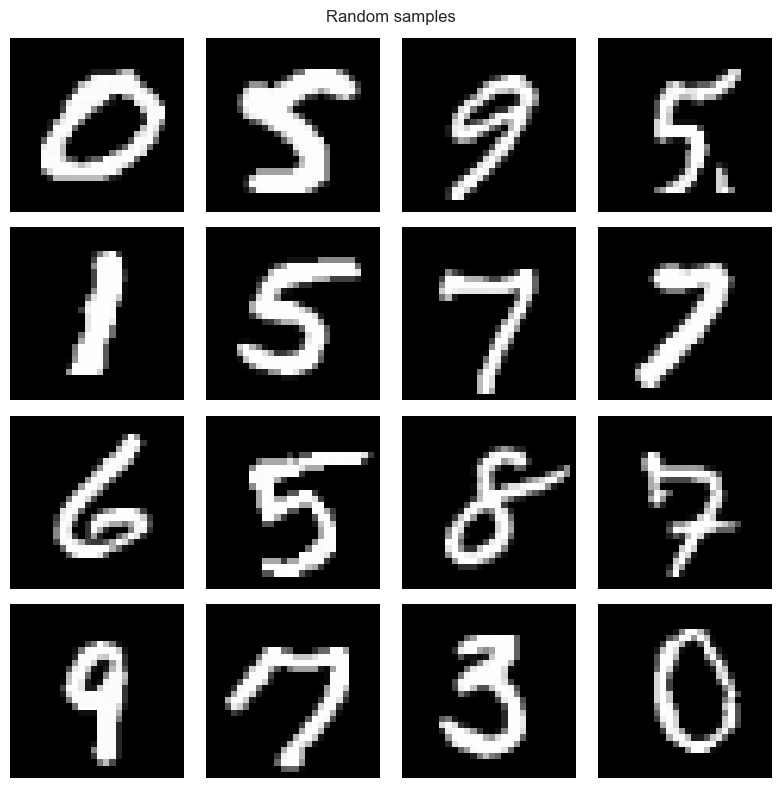

In [3]:
indexes = np.random.choice(range(0, X_train.shape[0]), size=16, replace=False)
samples = X_train[indexes]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for ax, sample in zip(axs.flatten(), samples):
    ax.imshow(sample, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Build an Autoencoder

In [4]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.n_hidden_1 = 256 # 1st layer num features
        self.n_hidden_2 = 128 # 2nd layer num features
        self.encoding_layer = 32
        self.n_input = 784 # MNIST data input (img shape: 28*28)

        self.flatten_layer = layers.Flatten()
        self.encoding_1 = layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.encoding_2 = layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.encoding_final = layers.Dense(self.encoding_layer, activation=tf.nn.relu)
        self.decoding_1 = layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.decoding_2 = layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.decoding_final = layers.Dense(self.n_input)

    # Building the encoder
    def encoder(self, x):
        x = self.flatten_layer(x)
        layer_1 = self.encoding_1(x)
        layer_2 = self.encoding_2(layer_1)
        code = self.encoding_final(layer_2)

        return code

    # Building the decoder
    def decoder(self, x):
        layer_1 = self.decoding_1(x)
        layer_2 = self.decoding_2(layer_1)
        decode = self.decoding_final(layer_2)

        return decode

    def call(self, x):
        encoder_op = self.encoder(x)
        # Reconstructed Images
        y_pred = self.decoder(encoder_op)

        return y_pred
        
def cost(y_true, y_pred):
    loss = losses.mean_squared_error(y_true, y_pred)
    cost = tf.reduce_mean(loss)
    
    return cost

def grad(model, inputs, targets):
    targets = layers.Flatten()(targets)

    with tf.GradientTape() as tape:    
        reconstruction = model(inputs)
        loss_value = cost(targets, reconstruction)

    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

## Train the model

In [5]:
learning_rate = 0.01
epochs = 20
batch_size = 256
total_batch = int(len(X_train) / batch_size)
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]

model = AutoEncoder()
optimizer = optimizers.RMSprop(learning_rate)
loss_values = []

for epoch in range(epochs):
    start_time = time.time()

    for i in range(total_batch):
        X_input = X_train[i * batch_size : i * batch_size + batch_size]
        loss_value, grads, reconstruction = grad(model, X_input, X_input)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_values.append(loss_value)

    # Display logs
    if epoch in epochs_to_show:
        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"\telapsed time: {(time.time() - start_time):.3f}s - cost: {loss_value:.4f}")

I0000 00:00:1741335489.101109  440631 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1723 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/20:
	elapsed time: 7.189s - cost: 0.0678
Epoch 2/20:
	elapsed time: 6.314s - cost: 0.0678
Epoch 4/20:
	elapsed time: 8.048s - cost: 0.0678
Epoch 6/20:
	elapsed time: 6.893s - cost: 0.0676
Epoch 8/20:
	elapsed time: 6.896s - cost: 0.0635
Epoch 10/20:
	elapsed time: 6.924s - cost: 0.0599
Epoch 12/20:
	elapsed time: 6.542s - cost: 0.0556
Epoch 14/20:
	elapsed time: 6.474s - cost: 0.0526
Epoch 16/20:
	elapsed time: 6.352s - cost: 0.0492
Epoch 18/20:
	elapsed time: 6.071s - cost: 0.0463
Epoch 20/20:
	elapsed time: 6.289s - cost: 0.0422


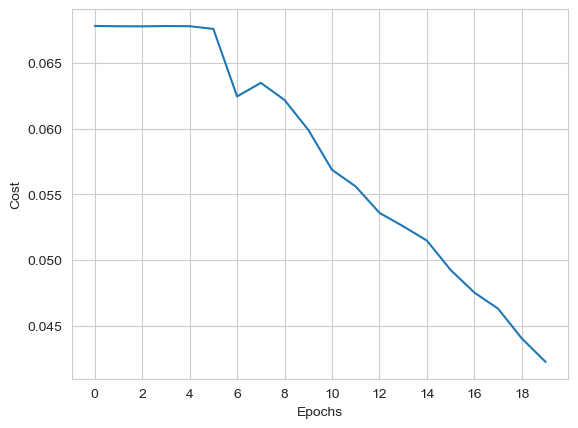

In [6]:
plt.figure()
plt.plot(loss_values)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.xticks(range(0, epochs, 2))
plt.show()

## Evaluate the model

The reconstructions were successful. It can be seen that some noise were added to the images.

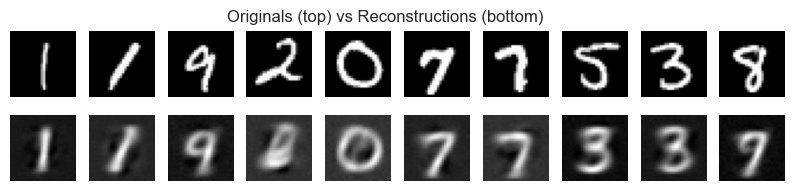

In [7]:
# Applying encode and decode over test set
indexes = np.random.choice(range(0, X_test.shape[0]), size=10, replace=False)
X_input = layers.Flatten()(X_test[indexes])
encode_decode = model(X_input)

# Compare original images with their reconstructions
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
plt.suptitle("Originals (top) vs Reconstructions (bottom)")

for i, index in enumerate(indexes):
    axs[0][i].imshow(np.reshape(X_test[index], (28, 28)), cmap="gray")
    axs[0][i].axis("off")
    
    axs[1][i].imshow(np.reshape(encode_decode[i], (28, 28)), cmap="gray")
    axs[1][i].axis("off")

plt.show()